In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F


# 1. Data Preprocessing
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 2. Transformer Autoencoder Model
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerAutoencoder, self).__init__()
        
        # Encoder
        self.input_linear = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, 
                                                 nhead=nhead,
                                                 dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, 
                                                       num_layers=num_encoder_layers)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, input_dim),
            nn.Sigmoid()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Add sequence dimension
        x = x.unsqueeze(0)
        
        # Encoder
        x = self.input_linear(x)
        latent = self.transformer_encoder(x)
        
        # Decoder
        decoded = self.decoder(latent.squeeze(0))
        
        # Classifier
        classification = self.classifier(latent.squeeze(0))
        
        return decoded, classification

# 3. Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            decoded, classification = model(features)
            
            # Compute reconstruction loss and classification loss
            recon_loss = criterion(decoded, features)
            class_loss = F.binary_cross_entropy(classification.squeeze(), labels)
            
            # Total loss
            loss = recon_loss + class_loss
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                decoded, classification = model(features)
                
                val_preds.extend(classification.squeeze().cpu().numpy())
                val_true.extend(labels.cpu().numpy())
                
                recon_loss = criterion(decoded, features)
                class_loss = F.binary_cross_entropy(classification.squeeze(), labels)
                loss = recon_loss + class_loss
                val_loss += loss.item()
        
        # Calculate ROC-AUC score
        roc_auc = roc_auc_score(val_true, val_preds)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}')
        print(f'ROC-AUC Score: {roc_auc:.4f}\n')

# 4. Main Execution

# Load and preprocess data
data = pd.read_csv('/kaggle/input/higgs-dataset/HIGGS.csv/HIGGS.csv')
features = data.iloc[:1100000, 1:22].values  # First 21 features
labels = data.iloc[:1100000, 0].values
    
# Split into train and test
train_features = features[:1000000]
train_labels = labels[:1000000]
test_features = features[1000000:]
test_labels = labels[1000000:]
    
# Standardize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
    
# Create datasets
train_dataset = CustomDataset(train_features, train_labels)
test_dataset = CustomDataset(test_features, test_labels)
    
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
# Initialize model
model = TransformerAutoencoder(
        input_dim=21,
        d_model=64,
        nhead=4,
        num_encoder_layers=2,
        dim_feedforward=128
)
model_path = "/kaggle/input/higgs-autoencoder-epoch-10/pytorch/default/1/higgs_autoencoder.pth"
model.load_state_dict(torch.load(model_path))
# Training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
    
# Train the model
#train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
#torch.save(model.state_dict(), "higgs_autoencoder.pth")
    

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-1-208fa5bf0600>:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

In [3]:
model = TransformerAutoencoder(
        input_dim=21,
        d_model=64,
        nhead=4,
        num_encoder_layers=2,
        dim_feedforward=128
)
model_path = "/kaggle/input/cms-autoencoder-epoch-40/pytorch/default/1/higgs_autoencoder (1).pth"
model.load_state_dict(torch.load(model_path))

<ipython-input-3-e36f10a7b224>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

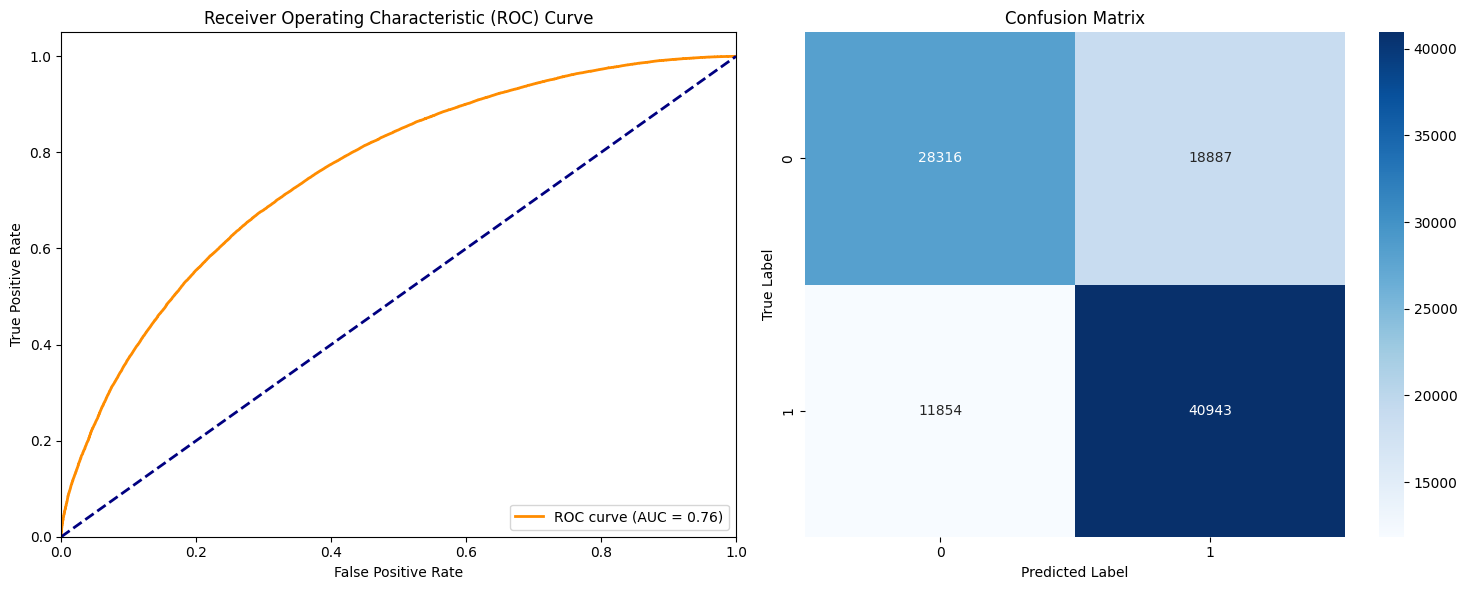

AUC Score: 0.7596
Optimal Threshold: 0.5507
Precision: 0.6843
Recall: 0.7755
F1 Score: 0.7271
Accuracy: 0.6926


In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Final evaluation on test set
model.eval()
test_preds = []
test_true = []
    
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        _, classification = model(features)
        test_preds.extend(classification.squeeze().cpu().numpy())
        test_true.extend(labels.numpy())

y_true = np.array(test_true)
y_scores = np.array(test_preds)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")
    
y_pred = (y_scores >= 0.5).astype(int)
    
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title('Confusion Matrix')
    
plt.tight_layout()
plt.show()
    
# Calculate additional metrics
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
    
# Compute precision, recall, F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
    
print(f"AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {np.mean(y_pred == y_true):.4f}")



